In [82]:
import torch

# test torch.utils.data.Subset

In [29]:
from torch.utils.data import Subset

from utils.dataset import BasicDataset
dataset = BasicDataset('./data/imgs/', './data/masks/', 1.0,mask_suffix='_mask')
size = len(dataset)

sets = []
leave_out_subsets = []

for i in range(size):
    #sets.append(BasicDataset('./data/imgs/', './data/masks/', 1.0,mask_suffix='_mask'))
    
    print('-'*75)
    
    train_indexs = list(range(size))
    train_indexs.remove(i)
    
    train = Subset(dataset,train_indexs)
    val = Subset(dataset,[i,])
    
    print(train.indices,train[0]['image'].shape)
    print(val.indices,val[0]['image'].shape)
    
    leave_out_subsets.append([train,val])
    
    
'''
    从源码来看：h%killbgscriptstps://pytorch.org/docs/master/_modules/torch/utils/data/dataset.html#Subset
    上面循环中的得到的各个subset都是共用同一个“父亲”dataset对象，但是这并%%sh任何的影响和干扰(从源码易懂)！
'''

---------------------------------------------------------------------------
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] torch.Size([1, 512, 512])
[0] torch.Size([1, 512, 512])
---------------------------------------------------------------------------
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] torch.Size([1, 512, 512])
[1] torch.Size([1, 512, 512])
---------------------------------------------------------------------------
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11] torch.Size([1, 512, 512])
[2] torch.Size([1, 512, 512])
---------------------------------------------------------------------------
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11] torch.Size([1, 512, 512])
[3] torch.Size([1, 512, 512])
---------------------------------------------------------------------------
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11] torch.Size([1, 512, 512])
[4] torch.Size([1, 512, 512])
---------------------------------------------------------------------------
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11] torch.Size([1, 512, 512])
[5] torch.Size([1, 512

'\n    从源码来看：h%killbgscriptstps://pytorch.org/docs/master/_modules/torch/utils/data/dataset.html#Subset\n    上面循环中的得到的各个subset都是共用同一个“父亲”dataset对象，但是这并%%sh任何的影响和干扰(从源码易懂)！\n'

In [33]:
for i in range(4):
    print(i%2)


0
1
0
1


In [36]:
import os

max_size = len(os.listdir('/GPUFS/sysu_rxwang_1/defeng/Pytorch-UNet/data/imgs/'))

max_size

12

# show diff and predict on  train set

显示在训练集上的train和val的结果。

In [3]:
import os
import logging 

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

#from tqdm import tqdm
from tqdm.notebook import tqdm

from dice_loss import dice_coeff

from PIL import Image
import cv2
import numpy as np

from torchvision import transforms

from unet import UNet
from utils.data_vis import plot_img_and_mask
from utils.dataset import BasicDataset

In [16]:
def leave_out_eval(net, loader, device,save_path,imgs_name):
    """Evaluation without the densecrf with the dice coefficient"""
    mask_type = torch.float32 if net.n_classes == 1 else torch.long
    
    flag=0
    with tqdm(total=len(loader), desc='Prediction round', unit='batch', leave=True) as pbar:
        for idx,batch in enumerate(loader):
            imgs, true_masks = batch['image'], batch['mask']
            imgs = imgs.to(device=device, dtype=torch.float32)
            #true_masks = true_masks.to(device=device, dtype=mask_type)
            
            
            with torch.no_grad():
                mask_pred = net(imgs)
            
            probs = torch.sigmoid(mask_pred)
            pred = probs>0.5 #pred:[8,512,512,1]
            pred = pred.cpu().numpy().astype(np.uint8).transpose(0,2,3,1) #pred:[8,512,512,1]
            if flag==0:
                flag=1
                np.save('probs.npy',probs.cpu().numpy())
            
            diff = pred - true_masks.cpu().numpy().astype(np.uint8).transpose(0,2,3,1) #diff:[8,512,512,1]
            diff = np.squeeze(diff,axis=-1) #diff:[8,512,512]
            #diff = diff.repeat([3],axis=-1)
            pred = pred*255
            blue = [255,0,0]
            red = [0,0,255]
            
            for i,pic in enumerate(pred):
                cv2.imwrite(os.path.join(save_path,imgs_name[i]),pic)
                
                color_diff = np.ones((*diff.shape[1:],3))
                color_diff[diff[i]==1] = blue #over estimate
                color_diff[diff[i]==-1] = red #under estimate
                cv2.imwrite(os.path.join(save_path,'diff_'+imgs_name[i]),color_diff)
                
                i+=1
            
            pbar.update(1)

In [17]:
if __name__ == "__main__":
    dir_img = 'data/imgs/'
    dir_mask = 'data/masks/'
    dataset = BasicDataset(dir_img, dir_mask, 1.0,mask_suffix='_mask')
    loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=8, pin_memory=False, drop_last=False)

    net = UNet(n_channels=1, n_classes=1)
    net.eval()

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')
    net.to(device=device)
    
    #name = 'backup4-DICE-UNet'
    name = 'backup3-BCE-UNet'
    
    cpkts_path = '/GPUFS/sysu_rxwang_1/defeng/%s/checkpoints/'%(name)
    cpkts_name = os.listdir(cpkts_path)
    
    save_path = '/GPUFS/sysu_rxwang_1/defeng/%s/data/val_result'%(name)
    imgs_name = os.listdir('/GPUFS/sysu_rxwang_1/defeng/%s/data/imgs/'%(name))
    
    for idx,group in enumerate(cpkts_name):
        net.load_state_dict(torch.load(os.path.join(cpkts_path,group,'best.pth'), map_location=device))
        print("Group:%s Model loaded !"%(group))
        
        path = os.path.join(save_path,group)
        if os.path.exists(path):
            import shutil
            shutil.rmtree(path, ignore_errors=True)
            print("deleting... Done!")
        os.mkdir(path)
        
        leave_out_eval(net,loader,device,path,imgs_name)

['5', '4', '10', '6', '12', '13', '1', '7', '0', '2', '8', '3']
Group:exp3_4 Model loaded !
deleting... Done!


Prediction round:   0%|          | 0/2 [00:00<?, ?batch/s]

Group:exp3_6 Model loaded !
deleting... Done!


Prediction round:   0%|          | 0/2 [00:00<?, ?batch/s]

Group:exp3_9 Model loaded !
deleting... Done!


Prediction round:   0%|          | 0/2 [00:00<?, ?batch/s]

Group:exp3_0 Model loaded !
deleting... Done!


Prediction round:   0%|          | 0/2 [00:00<?, ?batch/s]

Group:exp3_1 Model loaded !
deleting... Done!


Prediction round:   0%|          | 0/2 [00:00<?, ?batch/s]

Group:exp3_3 Model loaded !
deleting... Done!


Prediction round:   0%|          | 0/2 [00:00<?, ?batch/s]

Group:exp3_7 Model loaded !
deleting... Done!


Prediction round:   0%|          | 0/2 [00:00<?, ?batch/s]

Group:exp3_10 Model loaded !
deleting... Done!


Prediction round:   0%|          | 0/2 [00:00<?, ?batch/s]

Group:exp3_8 Model loaded !
deleting... Done!


Prediction round:   0%|          | 0/2 [00:00<?, ?batch/s]

Group:exp3_2 Model loaded !
deleting... Done!


Prediction round:   0%|          | 0/2 [00:00<?, ?batch/s]

Group:exp3_11 Model loaded !
deleting... Done!


Prediction round:   0%|          | 0/2 [00:00<?, ?batch/s]

Group:exp3_5 Model loaded !
deleting... Done!


Prediction round:   0%|          | 0/2 [00:00<?, ?batch/s]

# color map (can be exploited in the future)

In [204]:
img = cv2.imread('../backup4-UNet/data/val_result/exp3_0/diff_1.jpg',0)
img.shape

(512, 512)

In [163]:

def colormap(n):
    '''
    这里有19个颜色，根据自己数据来使用，也可以根据自己的喜爱修改颜色的值。n就是num_classes.
    np.uint8意味着array的值为0-255中间。
    cmap就是一个映射，当标签为1的时候，这个像素转换成RGB就是[244, 35,232]的三通道值。
    '''
    cmap=np.zeros([n, 3]).astype(np.uint8)
    cmap[0,:] = np.array([ 0,  0,  0])
    cmap[1,:] = np.array([244, 35,232])
    cmap[2,:] = np.array([ 70, 70, 70])
    cmap[3,:] = np.array([ 102,102,156])
    cmap[4,:] = np.array([ 190,153,153])
    cmap[5,:] = np.array([ 153,153,153])
 
    cmap[6,:] = np.array([ 250,170, 30])
    cmap[7,:] = np.array([ 220,220,  0])
    cmap[8,:] = np.array([ 107,142, 35])
    cmap[9,:] = np.array([ 152,251,152])
    cmap[10,:] = np.array([ 70,130,180])
 
    cmap[11,:] = np.array([ 220, 20, 60])
    cmap[12,:] = np.array([ 119, 11, 32])
    cmap[13,:] = np.array([ 0,  0,142])
    cmap[14,:] = np.array([  0,  0, 70])
    cmap[15,:] = np.array([  0, 60,100])
 
    cmap[16,:] = np.array([  0, 80,100])
    cmap[17,:] = np.array([  0,  0,230])
    cmap[18,:] = np.array([ 255,  0,  0])
    
    return cmap


In [206]:
class Colorize:
    def __init__(self, n=2):
        self.cmap = colormap(2)
        self.cmap[n] = self.cmap[-1]
        self.cmap = torch.from_numpy(self.cmap[:n])#array->tensor
 
    def __call__(self, gray_image):
        size = gray_image.size()#这里就是上文的output
        color_image = torch.ByteTensor(3, size[0], size[1]).fill_(0)
 
        for label in range(0, len(self.cmap)):
            mask = gray_image == label
            color_image[0][mask] = self.cmap[label][0]
            color_image[1][mask] = self.cmap[label][1]
            color_image[2][mask] = self.cmap[label][2]
 
        return color_image


# np.where is a disaster

In [214]:
temp = np.random.randn(2,2,3)
temp

array([[[-0.04584008, -1.10596792,  2.0051606 ],
        [ 0.59737921,  1.63828467, -0.29461262]],

       [[-1.45298915,  0.40394504,  1.3919785 ],
        [-0.4557085 ,  0.92478412, -0.48064994]]])

In [217]:
temp1 = np.where(temp==[-0.04584008, -1.10596792,  2.0051606],[255.0]*3,[1.0]*3)

In [218]:
temp1

array([[[1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.]]])

In [212]:
temp[0] = np.array([2.2,3.2,5.1])

In [213]:
temp

array([[[ 2.2       ,  3.2       ,  5.1       ],
        [ 2.2       ,  3.2       ,  5.1       ]],

       [[ 1.83185683,  0.09220815, -0.75080739],
        [ 0.04100745,  0.96471119,  1.06192293]]])

In [233]:
mask = np.random.randint(0,2,(4,4))
mask

array([[0, 1, 0, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

In [241]:
color_mask = np.ones((*mask.shape,3))
color_mask

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [242]:
blue = [255,0,0]
red = [0,0,255]

color_mask[mask==0] = blue
color_mask

array([[[255.,   0.,   0.],
        [  1.,   1.,   1.],
        [255.,   0.,   0.],
        [  1.,   1.,   1.]],

       [[255.,   0.,   0.],
        [255.,   0.,   0.],
        [  1.,   1.,   1.],
        [  1.,   1.,   1.]],

       [[255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [  1.,   1.,   1.]],

       [[255.,   0.,   0.],
        [  1.,   1.,   1.],
        [255.,   0.,   0.],
        [255.,   0.,   0.]]])

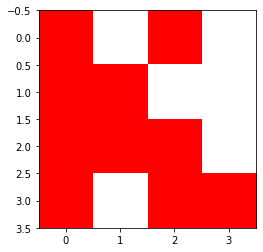

In [255]:
import matplotlib.pyplot as plt
plt.imshow(color_mask)

In [245]:
color_mask.shape[:-2]

(4,)

In [243]:
np.where(mask==1,blue,color_mask)

ValueError: operands could not be broadcast together with shapes (4,4) (3,) (4,4,3) 

# simple boolean index matrix can work.

<a color='red'>worked!</a>

In [267]:
mask = np.random.randint(0,2,(512,512))
diff = np.ones((512,512,3))
diff

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [268]:
diff[mask==1]=[255,0,0]

In [262]:
diff

array([[[  1.,   1.,   1.],
        [  1.,   1.,   1.],
        [255.,   0.,   0.],
        [255.,   0.,   0.]],

       [[255.,   0.,   0.],
        [  1.,   1.,   1.],
        [255.,   0.,   0.],
        [  1.,   1.,   1.]],

       [[255.,   0.,   0.],
        [  1.,   1.,   1.],
        [255.,   0.,   0.],
        [255.,   0.,   0.]],

       [[  1.,   1.,   1.],
        [255.,   0.,   0.],
        [  1.,   1.,   1.],
        [255.,   0.,   0.]]])

In [269]:
diff[0,3]

array([255.,   0.,   0.])

# border analysis

1. 取flat的序列，首先取出>0.5的数，然后进行排序，得到>0.5中的后10%的value值
2. 将1.中的value值作为threshold，然后去未flat的prob中筛选出对应的空间点，即 pred>0.5 and pred < value

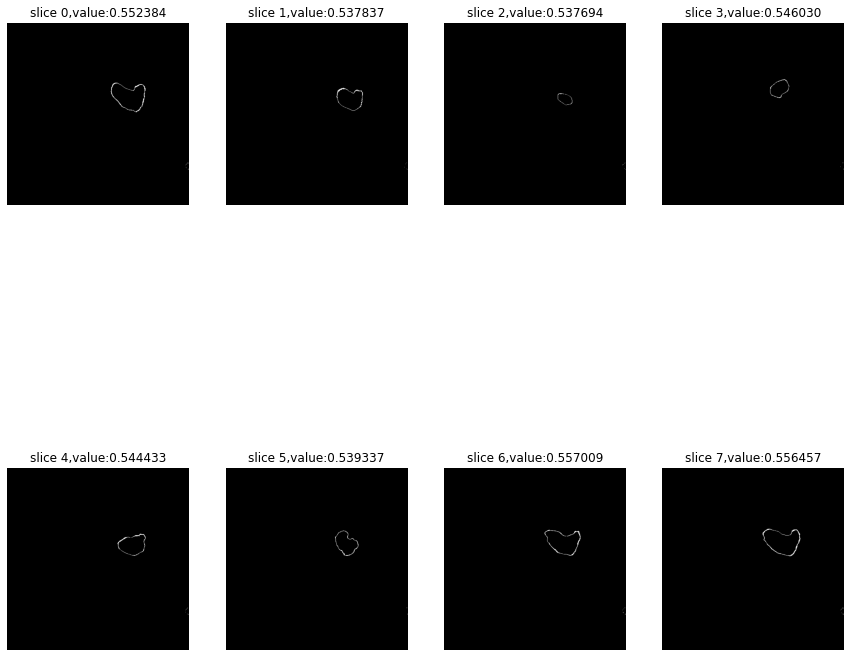

In [72]:
import matplotlib.pyplot as plt

rows = 2
cols = 4
fig,ax = plt.subplots(rows,cols,figsize=[15,15])
start_with = 0

probs = np.load('/GPUFS/sysu_rxwang_1/defeng/backup4-DICE-UNet/probs.npy').transpose(0,2,3,1)

for i in range(rows*cols):
    #ind = start_with + i*show_every
    
    pred = probs[i]

    mask = pred>0.5
    pred_flat = pred[mask].flatten()
    pred_flat.sort()
    percent = int(pred_flat.shape[0]*0.1)
    value = pred_flat[percent]

    points = (pred>0.5) & (pred<value)
    result = pred * points
    
    #print(int(i/cols),int(i%cols))
    ax[int(i/cols),int(i % cols)].set_title('slice %d,value:%f' % (i,value))
    ax[int(i/cols),int(i % cols)].imshow(result,cmap='gray')
    ax[int(i/cols),int(i % cols)].axis('off')

plt.show()


<mark>pytorch version</mark>

In [80]:
def cal_low_conf_pixels(probs,device):
    bs = probs.shape[0]
    results = torch.zeros(probs.shape).to(device)
    
    for i in range(bs):
        prob = probs[i]
        mask = prob>0.5
        pred_flat = prob[mask].flatten()
        pred_flat = pred_flat.sort()[0]
        percent = int(pred_flat.shape[0]*0.1)
        value = pred_flat[percent]

        points = (prob>0.5) & (prob<value)
        result = prob * points
        
        results[i] += result
        
    return results 

In [82]:
device = torch.device('cpu')

probs_torch = torch.from_numpy(probs)
results = cal_low_conf_pixels(probs_torch,device)

results_numpy = results.numpy()

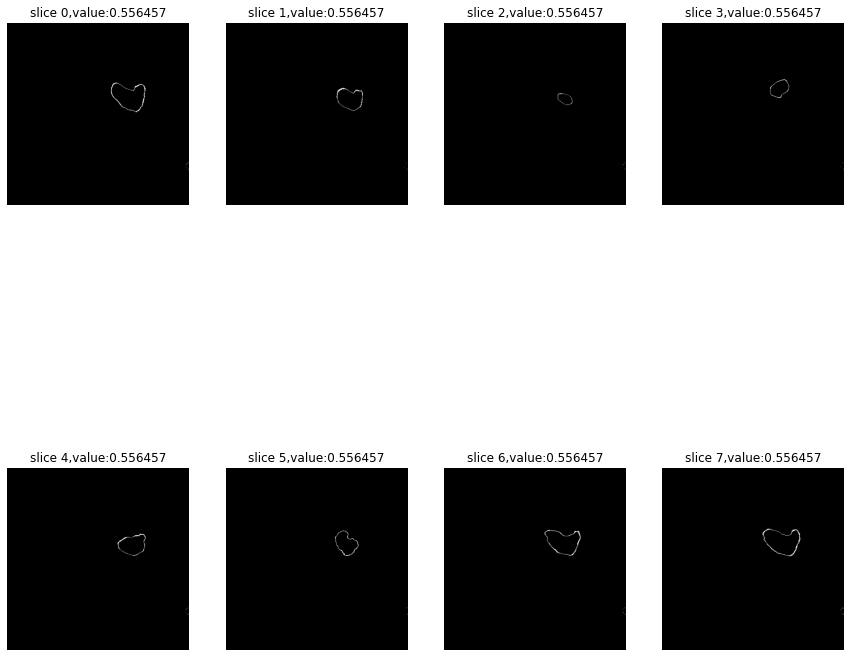

In [83]:
rows = 2
cols = 4
fig,ax = plt.subplots(rows,cols,figsize=[15,15])
start_with = 0

for i in range(rows*cols):
    pred = results_numpy[i]

#     mask = pred>0.5
#     pred_flat = pred[mask].flatten()
#     pred_flat.sort()
#     percent = int(pred_flat.shape[0]*0.1)
#     value = pred_flat[percent]

#     points = (pred>0.5) & (pred<value)
#     result = pred * points
    
    #print(int(i/cols),int(i%cols))
    ax[int(i/cols),int(i % cols)].set_title('slice %d,value:%f' % (i,value))
    ax[int(i/cols),int(i % cols)].imshow(pred,cmap='gray')
    ax[int(i/cols),int(i % cols)].axis('off')

plt.show()

可以看出，低置信度的区域都集中在边缘，所谓低置信度，其实就对应难样本，
所以有可能通过focal loss来改善边缘的预测

找到group3 outline的原因

focal loss

分析为什么区域比true_mask大的原因，是不是可能医生的标注比较保守？

仰文 UNet 分割 数据集 第六附属医院

可解释性，终身学习，异常检测，小样本，样本均衡

<mark>numpy/torch 对应sort()中axis参数的理解<br>具体见OneNote</mark>

In [46]:
d = torch.randint(0,2,(3,4))
d

tensor([[1, 1, 0, 1],
        [1, 0, 0, 1],
        [0, 1, 1, 0]])

In [14]:
probs = np.load('/GPUFS/sysu_rxwang_1/defeng/backup4-DICE-UNet/probs.npy')
probs.shape

(8, 1, 512, 512)

In [16]:
probs.sort(axis=0)

In [27]:
import torch
a = torch.randn((4,3))
a

tensor([[-1.5205, -0.1559,  0.2058],
        [ 0.3902,  0.9185,  2.5421],
        [ 0.0195, -0.4215, -1.1138],
        [ 0.7582, -1.0176, -1.1639]])

In [43]:
test = torch.randn((4,2,3))
sorted_tensor,sorted_index = test.sort(axis=0)
sorted_index

tensor([[[1, 0, 2],
         [0, 1, 2]],

        [[0, 2, 3],
         [1, 0, 1]],

        [[2, 1, 0],
         [2, 3, 3]],

        [[3, 3, 1],
         [3, 2, 0]]])

In [32]:
sorted_tensor,sorted_index = a.sort(axis=0)
sorted_tensor,sorted_index

(tensor([[-1.5205, -1.0176, -1.1639],
         [ 0.0195, -0.4215, -1.1138],
         [ 0.3902, -0.1559,  0.2058],
         [ 0.7582,  0.9185,  2.5421]]),
 tensor([[0, 3, 3],
         [2, 2, 2],
         [1, 0, 0],
         [3, 1, 1]]))

In [42]:
sorted_tensor,sorted_index = a.sort(axis=1)
sorted_tensor,sorted_index

(tensor([[-1.5205, -0.1559,  0.2058],
         [ 0.3902,  0.9185,  2.5421],
         [-1.1138, -0.4215,  0.0195],
         [-1.1639, -1.0176,  0.7582]]),
 tensor([[0, 1, 2],
         [0, 1, 2],
         [2, 1, 0],
         [2, 1, 0]]))

In [34]:
import numpy as np 
b = np.random.randn(4,3)
b 

array([[-0.20514859, -0.82950229, -1.54462652],
       [-1.33997226, -0.6520511 , -0.47617723],
       [ 1.16392028,  1.11151317,  0.29175784],
       [-1.45206545,  0.1465196 , -0.60927089]])

In [40]:
b.sort(axis=0)
b

array([[-1.45206545, -0.82950229, -1.54462652],
       [-1.33997226, -0.6520511 , -0.60927089],
       [-0.20514859,  0.1465196 , -0.47617723],
       [ 1.16392028,  1.11151317,  0.29175784]])

In [41]:
c = np.random.randn(3,2)
c_torch = torch.from_numpy(c)

c.sort(axis=0)

c,c_torch.sort(axis=0)[0]

(array([[-0.093291  , -1.99267183],
        [ 1.30498286, -1.39662903],
        [ 1.98327035,  0.39252396]]),
 tensor([[-0.0933, -1.9927],
         [ 1.3050, -1.3966],
         [ 1.9833,  0.3925]], dtype=torch.float64))

# DICE+FOCAL LOSS

<mark>下面的代码是错误的❌，正确的代码见dice_loss.ipynb</mark>

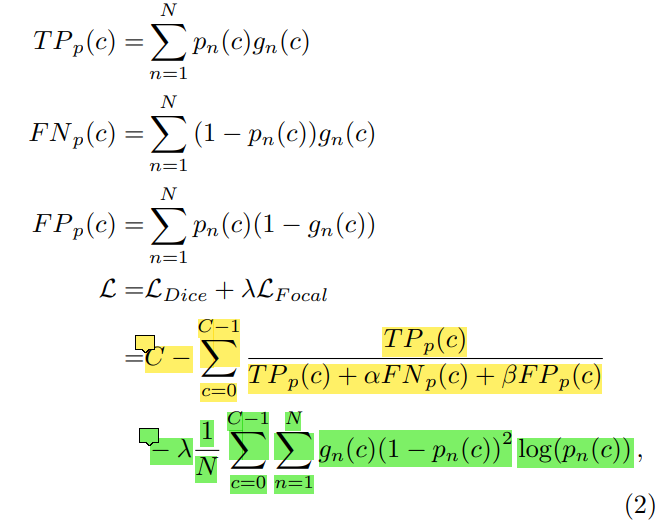

In [9]:
probs = np.load('./probs.npy')
#probs = probs.transpose(0,3,1,2)
probs = torch.from_numpy(probs)
probs.requires_grad = True

In [10]:
true_mask = torch.randint(0,2,probs.shape,dtype=torch.float32,requires_grad=True)

In [7]:
pred = probs>0.5

In [8]:
num_classes = 2 #2 includes background
classes_points = []

for i in range(num_classes):
    classes_points.append(pred==i)

In [223]:
TP = torch.zeros((num_classes,probs.shape[0]),dtype=torch.float32)
FP = torch.zeros((num_classes,probs.shape[0]),dtype=torch.float32)
FN = torch.zeros((num_classes,probs.shape[0]),dtype=torch.float32)

In [224]:
for i in range(num_classes):
    TP[i] = ((true_mask*probs)*classes_points[i]).sum(axis=(1,2,3))
    FN[i] = ((true_mask*(1.0-probs))*classes_points[i]).sum(axis=(1,2,3))
    FP[i] = (((1.0-true_mask)*probs)*classes_points[i]).sum(axis=(1,2,3))

In [225]:
TP,FP,FN

(tensor([[33371.2930, 33512.5742, 33726.1211, 34226.5469, 33598.1719, 33896.4102,
          33506.8242, 33285.5312],
         [ 1742.9943,  1125.8137,   351.3155,   632.7398,  1130.0732,   967.6789,
           1548.3789,  1843.3257]], grad_fn=<CopySlices>),
 tensor([[33398.7344, 33764.6758, 33756.8594, 33990.7539, 33657.3047, 33972.7188,
          33602.2383, 33476.4375],
         [ 1707.4255,  1110.6901,   354.6981,   662.2122,  1102.6460,   933.7745,
           1610.3724,  1760.8536]], grad_fn=<CopySlices>),
 tensor([[94956.6875, 95207.3594, 96700.8203, 96236.4297, 95571.8281, 95467.6094,
          94972.1484, 94630.4688],
         [ 1038.0059,   692.1862,   206.6845,   373.2602,   668.9267,   581.3210,
            900.6210,  1056.6743]], grad_fn=<CopySlices>))

In [226]:
alpha = beta = 0.5
lamb = 0.5

loss_dice = num_classes - (TP / (TP+alpha*FN+beta*FP)).sum(axis=0)
loss_focal = ((((true_mask-probs)**2)*torch.log(probs)).mean(axis=(1,2,3))) * lamb

In [201]:
((((true_mask-probs)**2)*torch.log(probs)).sum(axis=(1,2,3))) / (probs.shape[2]*probs.shape[3]) == ((((true_mask-probs)**2)*torch.log(probs)).mean(axis=(1,2,3)))

tensor([True, True, True, True, True, True, True, True])

In [227]:
loss = (loss_dice.mean()-loss_focal.mean())

In [3]:
def DICEandfocalLoss(probs,true_mask,device,num_classes=2):
	
	pred = probs>0.5
	classes_points = []
	for i in range(num_classes):
		classes_points.append(pred==i)

	
	TP = torch.zeros((num_classes),dtype=torch.float32).to(device)
	FP = torch.zeros((num_classes),dtype=torch.float32).to(device)
	FN = torch.zeros((num_classes),dtype=torch.float32).to(device)

	for i in range(num_classes):
		TP[i] = (probs[:,i] * true_mask[:,i]).sum(axis=(1,2)).mean()
		FN[i] = ((1.0-probs[:,i]) * true_mask[:,i]).sum(axis=(1,2)).mean()
		FP[i] = (probs[:,i] * (1-true_mask[:,i])).sum(axis=(1,2)).mean()
		
	
	alpha = beta = 0.5
	lamb = 0.5

	loss_dice = num_classes - (TP / (TP+alpha*FN+beta*FP)).sum()
	loss_focal = loss_focal = ((((true_mask-probs)**2)*torch.log(probs)).mean(axis=(1,2,3))) * lamb
	
	loss = loss_dice.mean()-loss_focal.mean()
	
	return loss

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
probs = probs.to(device)
true_mask = true_mask.to(device)

In [16]:
loss = DICEandfocalLoss(probs,true_mask,device)

In [17]:
loss.backward()